In [1]:
import soundfile as sf
import os
import numpy as np
import scipy as sp
from scipy.signal import get_window, butter, lfilter, freqz, stft
import matplotlib.pyplot as plt

### Observation
Let's first plot the signal and its spectrum. Note that the sound here has length of 456621 or 10 seconds.

In [2]:
x, srx = sf.read('anechoic1.wav')

In [3]:
x.shape

(456621,)

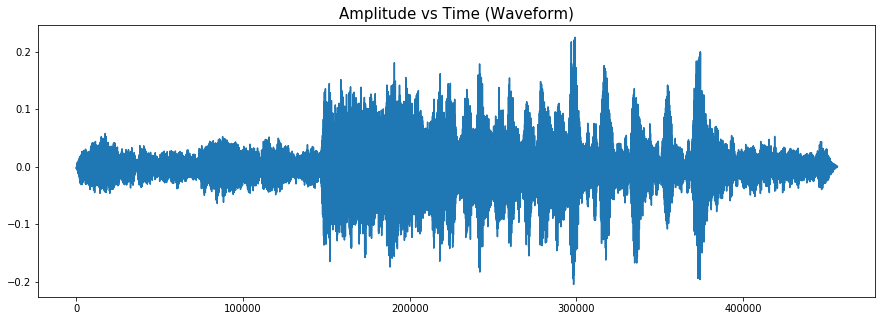

In [4]:
plt.figure(figsize=(15, 5))
plt.title("Amplitude vs Time (Waveform)", size=15)
plt.plot(x)

Text(0, 0.5, 'power')

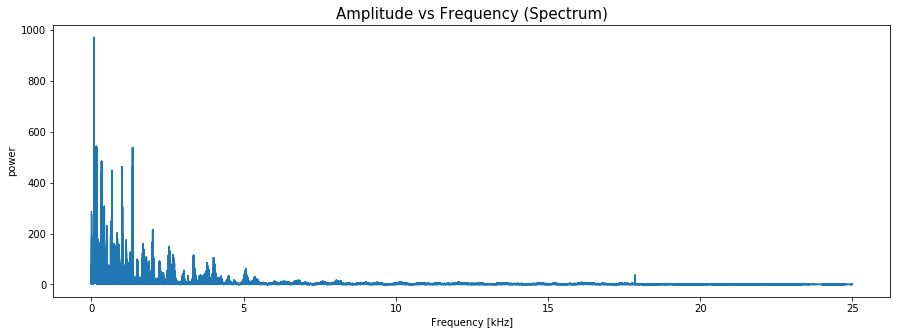

In [5]:
sig_fft = sp.fftpack.fft(x)
# And the power (sig_fft is of complex dtype)
power = np.abs(sig_fft)

# The corresponding frequencies
sample_freq = sp.fftpack.fftfreq(x.size, d=0.02)
# Plot the FFT power
plt.figure(figsize=(15, 5))
plt.plot(np.abs(sample_freq), power)
plt.title("Amplitude vs Frequency (Spectrum)", size=15)
plt.xlabel('Frequency [kHz]')
plt.ylabel('power')

I also created a Short Time Fourier Transform to break down the sound to differnt segments. 

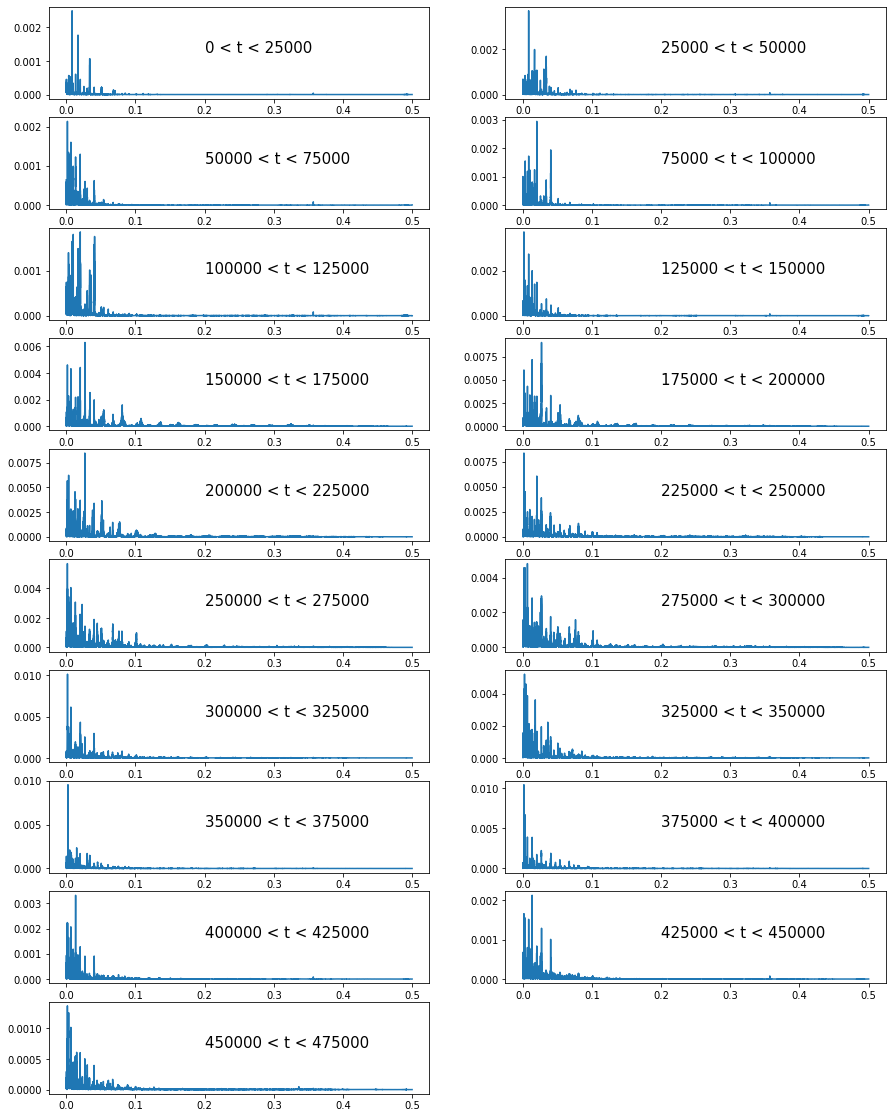

In [6]:
# original stft graph (without noise)
f, t, Zxx = sp.signal.stft(x, nperseg=50000)
# show 19 segments
fig = plt.figure(figsize=(15, 20))

for i in range(1, 20):
    ax = plt.subplot(10, 2, i)
    ax.text(0.2, np.max(np.abs(Zxx[:, i-1]))/2, "{0} < t < {1}".format(int(t[i-1]), int(t[i])), size=15)
    plt.plot(f, np.abs(Zxx[:, i-1]))
plt.show()

### Add noise to uncorrupted signal
I created a random noise with a normal distribution and added it to the original signal at 250000 - 275000. 

In [7]:
# random noise with normal distribution
noise = np.random.normal(scale=1e-2,
                         size=25000)

# create a copy of x; only change part of the sound
composed = np.copy(x)
composed[250000:275000] = composed[250000:275000] + noise

If I plot the waveform and spectrum of this corrupted sound, it is visible the corrupted signal is different than the original sound (from the spectrum plot), but it is hard to tell where the noise present from the waveform plot directly.

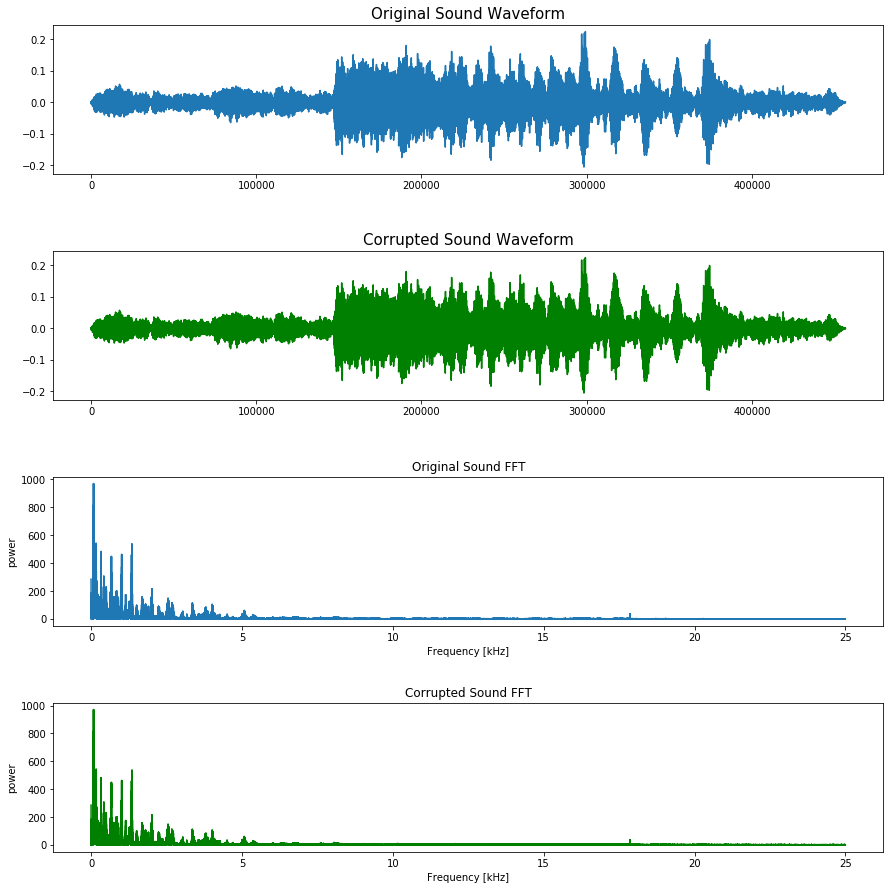

In [8]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(13,13))
# ax1.figure(figsize=(15, 5))
ax1.plot(x)
ax1.set_title("Original Sound Waveform", size=15)

# ax2.figure(figsize=(15, 5))
ax2.plot(composed, c='g')
ax2.set_title("Corrupted Sound Waveform", size=15)

sig_fft = sp.fftpack.fft(x)
power = np.abs(sig_fft)
sample_freq = sp.fftpack.fftfreq(x.size, d=0.02)
# ax3.figure(figsize=(15, 5))
ax3.plot(np.abs(sample_freq), power)
ax3.set_xlabel('Frequency [kHz]')
ax3.set_ylabel('power')
ax3.set_title('Original Sound FFT')

sig_fft = sp.fftpack.fft(composed)
power = np.abs(sig_fft)
sample_freq = sp.fftpack.fftfreq(x.size, d=0.02)
# ax4.figure(figsize=(15, 5))
ax4.plot(np.abs(sample_freq), power, c='g')
ax4.set_xlabel('Frequency [kHz]')
ax4.set_ylabel('power')
ax4.set_title('Corrupted Sound FFT')

fig.tight_layout(pad=3.0)
plt.show()

### Where is the noise
However, if I plot the STFT graph for the corrupted signal, one could tell where the noise is. The two plots that range from 250000 to 300000 have higher power on the tails. That's the noise!

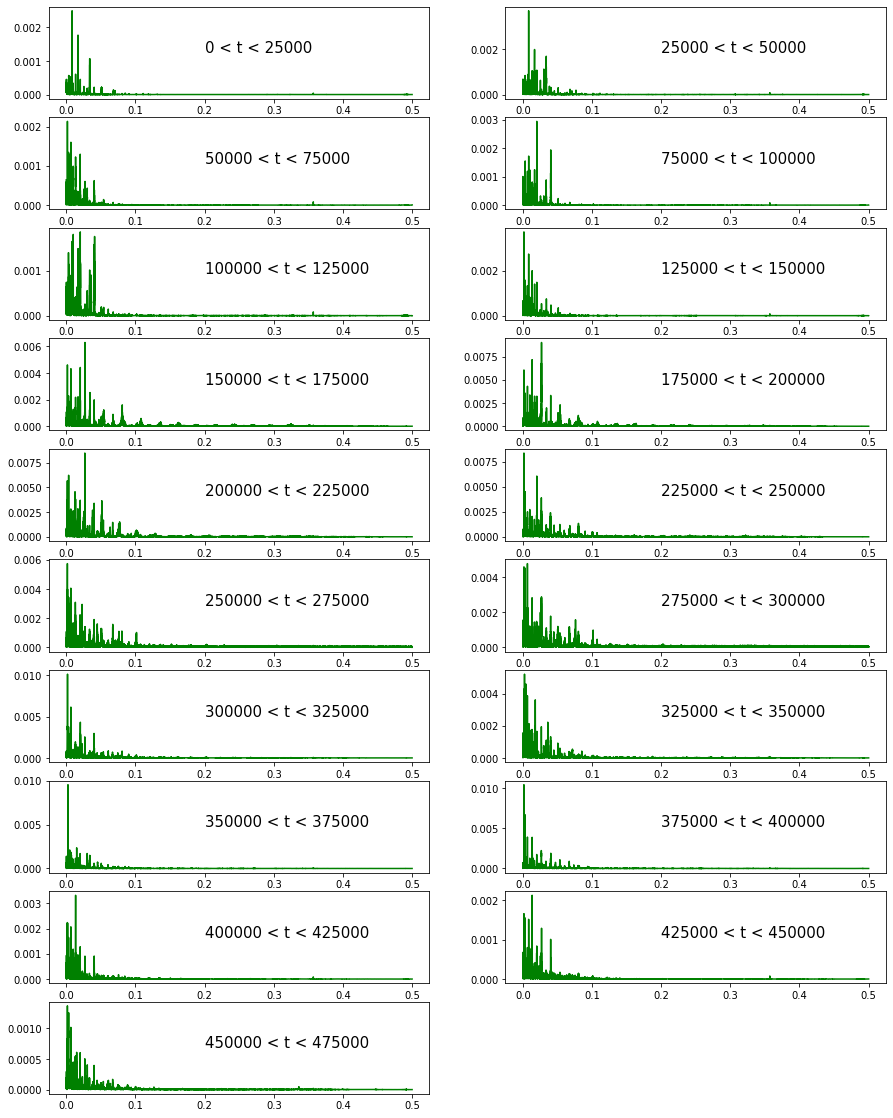

In [9]:
### stft graph with noise
f_composed, t, Zxx_composed = sp.signal.stft(composed, nperseg=50000)
### show first 6 time segments
fig = plt.figure(figsize=(15, 20))

for i in range(1, 20):
    ax = plt.subplot(10, 2, i)
    ax.text(0.2, np.max(np.abs(Zxx_composed[:, i-1]))/2, "{0} < t < {1}".format(int(t[i-1]), int(t[i])), size=15)
    plt.plot(f_composed, np.abs(Zxx_composed[:, i-1]), c='g')
plt.show()

#### To mkae it more clear, let's zoom in the 250000 to 300000 portion of the signal for original sound and corrupted sound, respectively.

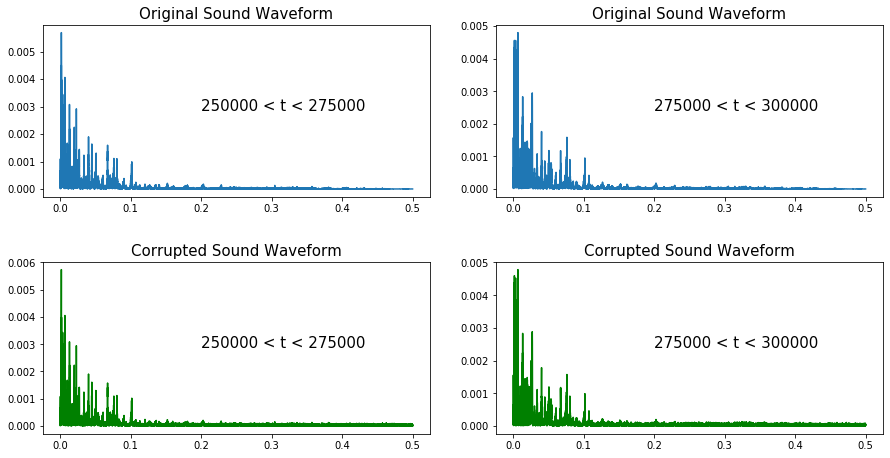

In [10]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13,7))
# ax1.figure(figsize=(15, 5))
ax1.text(0.2, np.max(np.abs(Zxx[:, 10]))/2, "{0} < t < {1}".format(int(t[10]), int(t[11])), size=15)
ax1.plot(f, np.abs(Zxx[:, 10]))
ax1.set_title("Original Sound Waveform", size=15)

ax2.text(0.2, np.max(np.abs(Zxx[:, 11]))/2, "{0} < t < {1}".format(int(t[11]), int(t[12])), size=15)
ax2.plot(f, np.abs(Zxx[:, 11]))
ax2.set_title("Original Sound Waveform", size=15)

ax3.text(0.2, np.max(np.abs(Zxx_composed[:, 10]))/2, "{0} < t < {1}".format(int(t[10]), int(t[11])), size=15)
ax3.plot(f, np.abs(Zxx_composed[:, 10]), c='g')
ax3.set_title("Corrupted Sound Waveform", size=15)

ax4.text(0.2, np.max(np.abs(Zxx_composed[:, 11]))/2, "{0} < t < {1}".format(int(t[11]), int(t[12])), size=15)
ax4.plot(f, np.abs(Zxx_composed[:, 11]), c='g')
ax4.set_title("Corrupted Sound Waveform", size=15)

fig.tight_layout(pad=3.0)
plt.show()

Clearly, we could see the tails of the last two plots are much more obvious than the first two. We have found the noise! In fact, we could find noise that added to any part of the signal easily using this idea. If the large segment doesn't tell anything, searching in a smaller range might find the noise! 

### Remove the Noise
Here, I will show how to remove (partially) the noise from the corrupted signal by using band pass filter. As we observed from the previous plot, the main difference between corrupted sound and original sound is the power in the high frequency range. The power of the original sound signal is very low, whereas the power of corrupted signal is very high. Thus, if we could surpass the high frequency signal, we could eliminate the noise (partially).

In [11]:
def lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=5):
    b, a = lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter configuration
order = 6
fs = 30.0
cutoff = 3

In [12]:
filtered = lowpass_filter(composed[250000:275000], cutoff, fs, order)

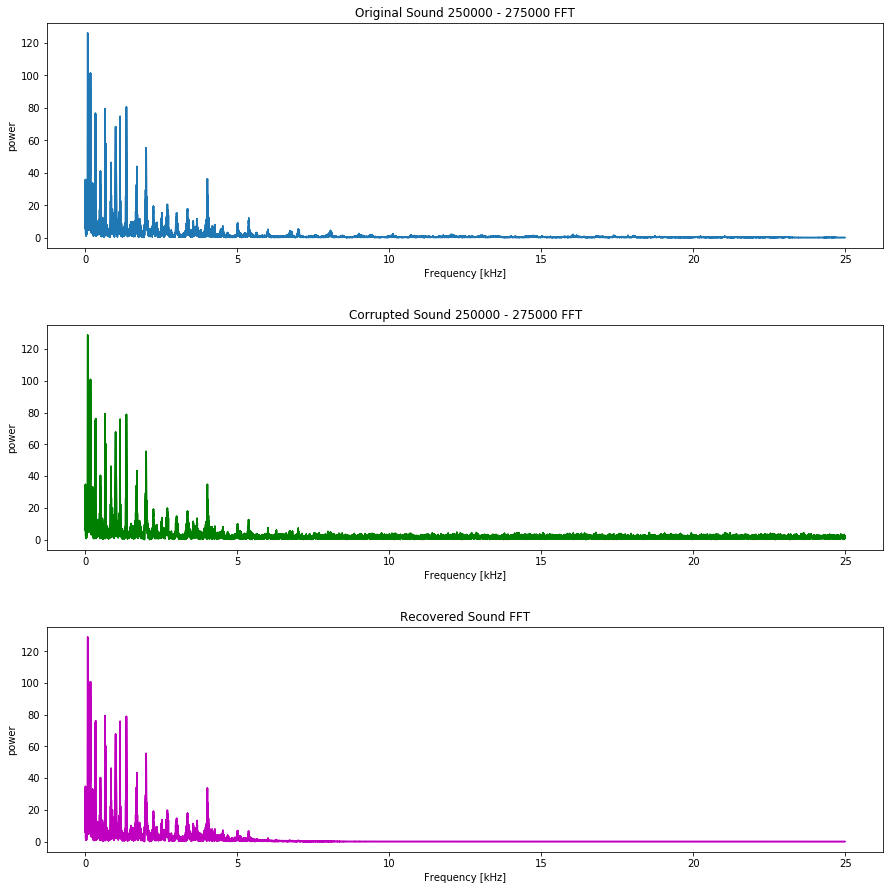

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(13,13))

sig_fft = sp.fftpack.fft(x[250000:275000])
power = np.abs(sig_fft)
sample_freq = sp.fftpack.fftfreq(25000, d=0.02)
# ax3.figure(figsize=(15, 5))
ax1.plot(np.abs(sample_freq), power)
ax1.set_xlabel('Frequency [kHz]')
ax1.set_ylabel('power')
ax1.set_title('Original Sound 250000 - 275000 FFT')
      
sig_fft = sp.fftpack.fft(composed[250000:275000])
power = np.abs(sig_fft)
sample_freq = sp.fftpack.fftfreq(25000, d=0.02)
# ax3.figure(figsize=(15, 5))
ax2.plot(np.abs(sample_freq), power, c='g')
ax2.set_xlabel('Frequency [kHz]')
ax2.set_ylabel('power')
ax2.set_title('Corrupted Sound 250000 - 275000 FFT')

sig_fft = sp.fftpack.fft(filtered)
power = np.abs(sig_fft)
sample_freq = sp.fftpack.fftfreq(25000, d=0.02)
# ax3.figure(figsize=(15, 5))
ax3.plot(np.abs(sample_freq), power, c='m')
ax3.set_xlabel('Frequency [kHz]')
ax3.set_ylabel('power')
ax3.set_title('Recovered Sound FFT')

fig.tight_layout(pad=3.0)
plt.show()